<a href="https://colab.research.google.com/github/NoeGille/UNet-on-fashion-mnist/blob/main/UNet_on_Florian's_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Code for UNet model found on

https://www.augustehoangduc.fr/comment-implementer-u-net-pour-faire-de-la-segmentation-dimage/

In [112]:
import keras.datasets.fashion_mnist as fashion_mnist

# Load data
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

(60000, 28, 28)
[9 0 0 ... 3 0 5]


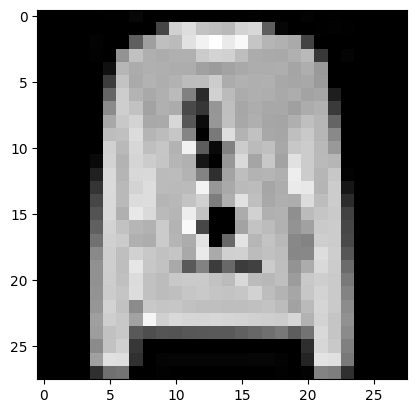

In [113]:
import numpy as np
import matplotlib.pyplot as plt
from random import choice
import cv2

plt.imshow(choice(X_train), cmap='gray')
print(X_train.shape)
print(y_train)

In [114]:
# CONSTANTS

IMG_SHAPE = (28, 28, 1)

def create_y(X):
  y = np.array([cv2.threshold(img, 8, 255, type=cv2.THRESH_BINARY)[1] for img in X])
  y_inv = np.array(cv2.bitwise_not(y))
  res = np.stack([y, y_inv], axis=3)
  return np.array(y_inv)


y_train = create_y(X_train)
y_test = create_y(X_test)


In [115]:
X_train = ((np.array(np.expand_dims(X_train, axis=-1), dtype=np.float64) - X_train.mean()) / np.sqrt(X_train.var()))
y_train = np.array(np.expand_dims(y_train, axis=-1), dtype=np.float64)

-1.74808013869143e-17
1.0000000000000002


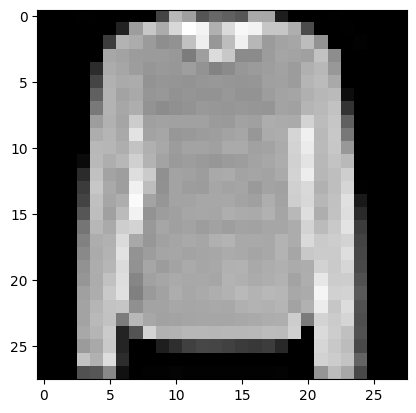

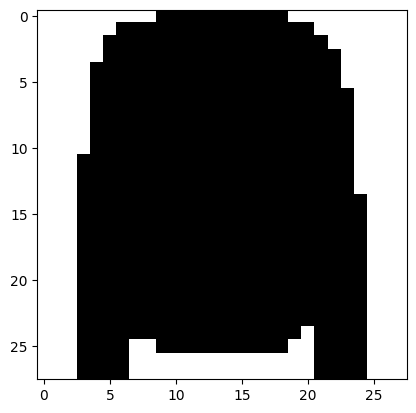

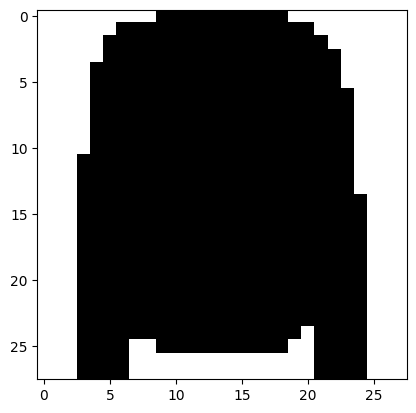

In [116]:
print(X_train.mean())
print(X_train.var())
n = np.random.randint(0, 60000)
plt.imshow(X_train[n],cmap='gray')
plt.show()
plt.imshow(y_train[n,:,:],cmap='gray')
plt.show()
plt.imshow(y_train[n,:,:],cmap='gray')
plt.show()

In [117]:
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dense, Concatenate, Input


def create_model():
    def DoubleConvolution(filters, inputs):
        """
        Double convolution layer used at every down sample and residual connection
        filters : outputs filter dimension
        inputs : input tensor
        """
        y = Conv2D(filters = filters, 
                   kernel_size = (3,3), 
                   padding = 'same',
                   kernel_initializer='he_normal', 
                   activation='elu')(inputs)
        y = Conv2D(filters = filters, 
                   kernel_size = (3,3), 
                   padding = 'same', 
                   kernel_initializer='he_normal', 
                   activation='relu')(y)
        return y
    def DownSample(filters, inputs):
        """
        Reduce size of image
        filters : outputs filter dimension
        inputs : input tensor
        """
        y = MaxPooling2D(pool_size=(2,2), padding='valid')(inputs)
        y = DoubleConvolution(filters, y)
        return y
    
    def UpSample(filters, inputs):
        """
        Increase size of image
        filters : outputs filter dimension
        inputs : input tensor
        """
        y = UpSampling2D(size=(2,2))(inputs)
        y = Conv2D(filters=filters, kernel_size=(3,3), activation='elu', padding='same')(y)
        return y

    def ResidualConnection(filters, input_1, input_2):
        """
        Concatenate inputs of two blocks
        filters : outputs filter dimension
        input_1 : first input
        input_2 : second input
        """
        y = Concatenate(axis=-1)([input_1, input_2])
        y = DoubleConvolution(filters, y)
        return y
      
    input = Input(shape=(IMG_SHAPE))

    #shape =(28, 28, 1)
    Conv0 = DoubleConvolution(64, input)
    #shape =(28, 28, 64)
    Conv1 = DownSample(128, Conv0)
    #shape =(14, 14, 128)
    Conv2 = DownSample(256, Conv1)
    #shape =(7, 7, 256)

    UpConv1 = UpSample(128, Conv2)
    Res1 = ResidualConnection(128, Conv1, UpConv1)
    #shape =(14, 14, 128)

    UpConv0 = UpSample(128, UpConv1)
    Res0 = ResidualConnection(64, Conv0, UpConv0)
    #shape =(28, 28, 64)

    output = Conv2D(1, kernel_size=(1,1), activation = 'sigmoid')(Res0) # shape = (28, 28, 2)

    return Model(input, output)

In [118]:
model = create_model()

In [121]:
from keras.metrics import MeanIoU
from keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=['accuracy'])
model.summary()

Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 lambda_11 (Lambda)             (None, 28, 28, 1)    0           ['input_19[0][0]']               
                                                                                                  
 conv2d_212 (Conv2D)            (None, 28, 28, 16)   160         ['lambda_11[0][0]']              
                                                                                                  
 dropout_55 (Dropout)           (None, 28, 28, 16)   0           ['conv2d_212[0][0]']             
                                                                                           

In [124]:
from keras.layers import Lambda, Dropout, Conv2DTranspose, concatenate
inputs = Input(IMG_SHAPE)

s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c5 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)

u8 = Conv2DTranspose(32, (2, 2), strides=(2,2), padding='same') (c5)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

3750/3750 [==============================] - 36s 9ms/step - loss: nan - accuracy: 0.4483


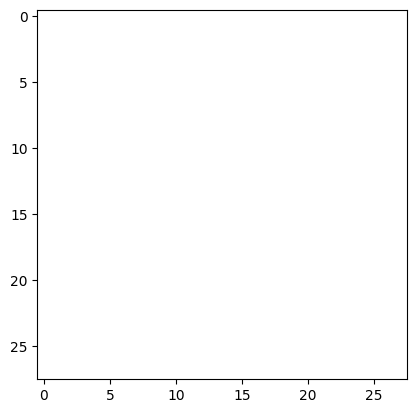

In [125]:

BATCH_SIZE = 16
model.fit(x=X_train, y=y_train, batch_size=BATCH_SIZE, epochs=1, steps_per_epoch=len(X_train) // BATCH_SIZE, verbose=1)

plt.imshow(prediction[1], cmap='gray')
plt.show()


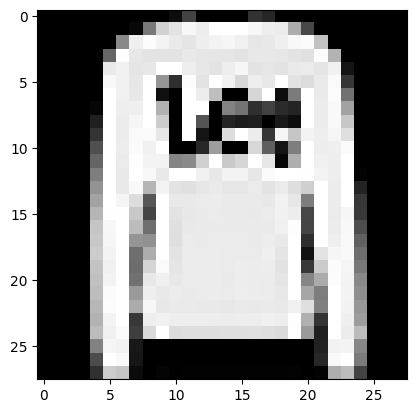

313/313 [==============================] - 1s 3ms/step


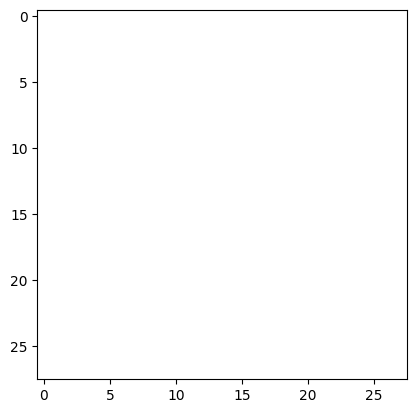

In [111]:
plt.imshow(X_test[1], cmap='gray')
plt.show()
prediction = model.predict(X_test)

plt.imshow(prediction[1], cmap='gray')
plt.show()